In [9]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
from PIL import Image
# from tqdm import tqdm   


In [6]:
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.001
NUM_CLASSES = 15
INPUT_SIZE = (224, 224)
CHANNELS = 3

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, tranform=None):
        self.data_dir = data_dir
        self.transorm = tranform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        self._load_data()

    def _load_data(self):
        """load the dataset from the directory"""

        for class_idx, class_name in enumerate(sorted(os.listdir(self.data_dir))):
            class_dir = os.path.join(self.data_dir, class_name)
            if os.path.isdir(class_dir):
                self.class_to_idx[class_name] = class_idx
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                        self.image_paths.append(img_path)
                        self.labels.append(class_idx)

    def __len__(self):
        """return the size of the data"""

        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """return tuple (image, label)"""

        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")

        if self.transorm:
            img = self.transorm(img)
        
        return img, label

In [9]:
transform = {
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        ]),

    "test": transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
    ])
}

def load_data():
    global transform
    train_dataset = CustomDataset("../data/train", transform["train"])
    val_dataset = CustomDataset("../data/val", transform["test"])
    test_dataset = CustomDataset("../data/test", tranform=transform["test"])


    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader

In [5]:
class BallsClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32 * 28 * 28, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=15)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        out = self.classifier(x)
        return out

In [6]:
def train_val_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in tqdm(range(epochs)):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for X, y in train_loader:
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, preds = output.max(1)
            correct_train += (preds == y).sum().item()
            total_train += y.size(0)

        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        running_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for X, y in val_loader:
                output = model(X)
                running_val_loss += criterion(output, y).item()
                
                _, preds = output.max(1)
                correct_val += (preds == y).sum().item()
                total_val += y.size(0)

        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")



    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [7]:
import matplotlib.pyplot as plt


def plot_curves(training, validation, title):
    plt.figure(figsize=(10, 5))
    plt.plot(training, label='Train Loss')
    plt.plot(validation, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train vs Validation {title}')
    plt.legend()
    plt.show()

start loading data
ended loading data
-----------------------------------------------

start training


 20%|██        | 1/5 [06:09<24:36, 369.22s/it]

Epoch 1/5, Train Loss: 0.9743, Train Acc: 0.6254, Val Loss: 0.5054, Val Acc: 0.8048


 40%|████      | 2/5 [10:10<14:41, 293.74s/it]

Epoch 2/5, Train Loss: 0.2785, Train Acc: 0.9073, Val Loss: 0.0821, Val Acc: 0.9783


 60%|██████    | 3/5 [14:01<08:50, 265.31s/it]

Epoch 3/5, Train Loss: 0.0685, Train Acc: 0.9803, Val Loss: 0.0344, Val Acc: 0.9930


 80%|████████  | 4/5 [17:39<04:06, 246.62s/it]

Epoch 4/5, Train Loss: 0.0233, Train Acc: 0.9940, Val Loss: 0.0046, Val Acc: 1.0000


100%|██████████| 5/5 [21:31<00:00, 258.40s/it]

Epoch 5/5, Train Loss: 0.0166, Train Acc: 0.9961, Val Loss: 0.0086, Val Acc: 0.9984


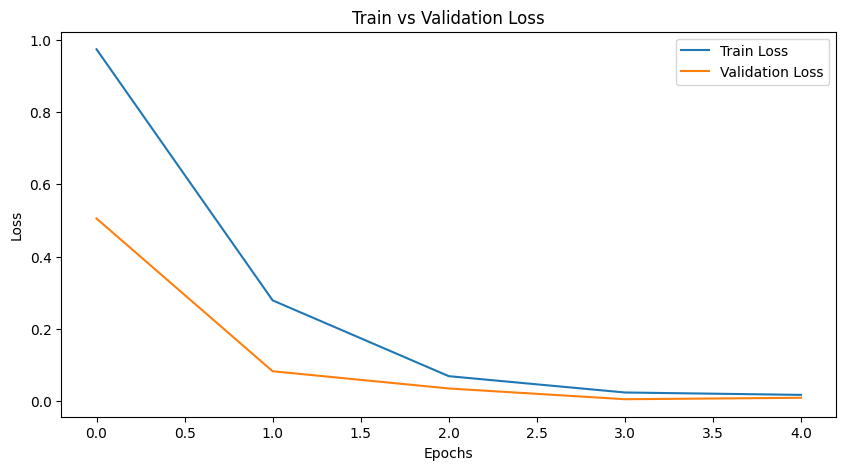

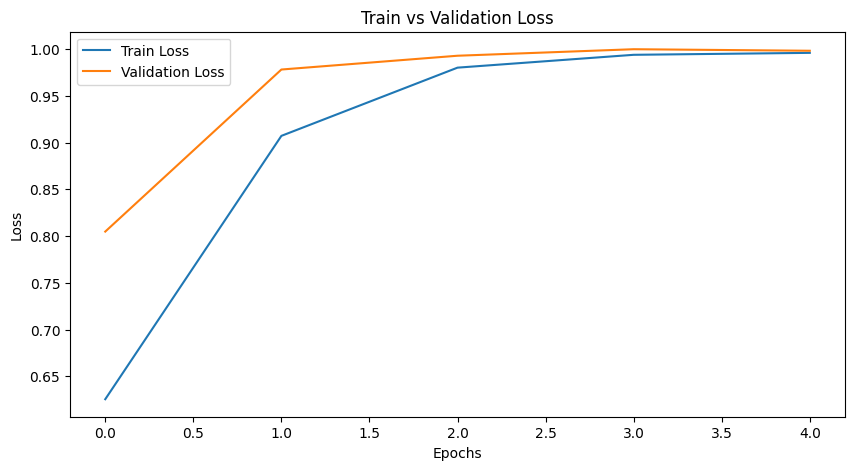

In [8]:

print("start loading data")
train, val, test = load_data()
print("ended loading data\n-----------------------------------------------\n")


model = BallsClassification()

critirion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)


print("start training")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_val_model(model=model,
                                                                                    train_loader=train,
                                                                                    val_loader=val,
                                                                                    criterion=critirion,
                                                                                    optimizer=optimizer,
                                                                                    epochs=EPOCHS)


plot_curves(training=train_losses, validation=val_losses)
plot_curves(training=train_accuracies, validation=val_accuracies)

In [9]:

def evaluate_model(model, test_loader, criterion):
    running_test_loss = 0
    correct_test = 0
    total_test = 0
    model.eval()
    with torch.no_grad():
        for img, label in test_loader:
            output = model(img)
            running_test_loss += criterion(output, label).item()

            _, preds = output.max(1)
            correct_test += (preds == label).sum().item()
            total_test += label.size(0)

    avg_test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test
    print()
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return avg_test_loss, test_accuracy


evaluate_model(model=model, test_loader=test, criterion=critirion)


Test Loss: 0.0094, Test Accuracy: 0.9980


(0.00938667795217043, 0.998015873015873)

In [11]:
# torch.save(model.state_dict(), "./models/model2.pth")